In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, chi2
import scipy.stats as stats
import statsmodels.stats.api as sms
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [51]:
data= pd.read_csv('/content/ab testing for web optimization.csv')
data.head()

,User_ID,Group,Version_A_Clicks,Version_B_Clicks,Time_Spent,Bounced,Device_Type,Age_Group,Location,Traffic_Source
0,1,A,10,12,30,0,Desktop,25-34,United States,Organic search
1,2,B,8,14,45,0,Mobile,18-24,United Kingdom,Social media
2,3,A,15,9,25,1,Tablet,35-44,Canada,Referral
3,4,B,12,16,60,0,Desktop,45-54,Australia,Direct
4,5,A,6,5,15,1,Mobile,18-24,Germany,Organic search


In [52]:
data.drop(['Version_A_Clicks','Version_B_Clicks'], axis=1, inplace=True)

In [53]:
data.isna().sum()

User_ID           0
Group             0
Time_Spent        0
Bounced           0
Device_Type       0
Age_Group         0
Location          0
Traffic_Source    0
dtype: int64

In [54]:
data.duplicated().sum()

0

In [55]:
control_group = data[data['Group'] == 'A']
experimental_group = data[data['Group'] == 'B']

In [56]:
control_group.shape

(53, 8)

In [57]:
experimental_group.shape

(47, 8)

In [58]:
control_group.head()

,User_ID,Group,Time_Spent,Bounced,Device_Type,Age_Group,Location,Traffic_Source
0,1,A,30,0,Desktop,25-34,United States,Organic search
2,3,A,25,1,Tablet,35-44,Canada,Referral
4,5,A,15,1,Mobile,18-24,Germany,Organic search
5,6,A,20,0,Desktop,35-44,France,Organic search
7,8,A,28,0,Tablet,18-24,Italy,Referral


In [59]:
experimental_group.head()

,User_ID,Group,Time_Spent,Bounced,Device_Type,Age_Group,Location,Traffic_Source
1,2,B,45,0,Mobile,18-24,United Kingdom,Social media
3,4,B,60,0,Desktop,45-54,Australia,Direct
6,7,B,75,0,Mobile,25-34,Spain,Social media
9,10,B,40,0,Desktop,35-44,United Kingdom,Organic search
11,12,B,48,1,Desktop,18-24,United States,Social media


**We want to see if there is any significant difference between both groups. So we will use two tailed test.**



---


* null hypothesis: H0: P = P0
* alternative hypothesis: H1: P != P0
where P and P0 stands for bounce rate of the new and old page respectively.
* The confidence level will be set as 95% or 0.95. Hence, alpha = 1 - 0.95 = 0.05

# Deciding Metric
To decide whether the new page is more successful.
---
To measure this success rate, we can use the bounce rate. Using the column 'bounced', we can calculate the mean of each group ( control and experimental) to get the bounce rate of each page.

In [60]:
pd.DataFrame(data['Group'].value_counts())

,Group
A,53
B,47


In [61]:
conversion_rates = data.groupby('Group')['Bounced']

std_p = lambda x: np.std(x, ddof= 0)
se_p = lambda x: stats.sem(x, ddof= 0)

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])

conversion_rates.columns = ['conversion_rate','std_deviation', 'std_error']

conversion_rates.style.format('{:.5f}')

,conversion_rate,std_deviation,std_error
Group,,,
A,0.30189,0.45908,0.06306
B,0.29787,0.45732,0.06671


**It seems like the new page performs worse than the old page**

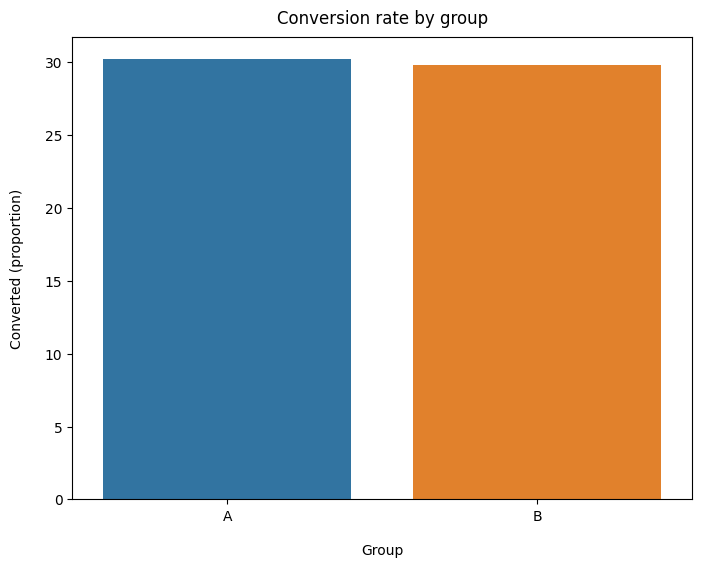

In [62]:
plt.figure(figsize=(8,6))

sns.barplot(x=data['Group'], y=data['Bounced']*100, ci=False)

plt.title('Conversion rate by group', pad=10)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

**Initial evidence suggests that there is no significant difference in convergence between treatment and control groups. However,  we will try doing hypothesis testing to see whether the above evidence are backed statistically.**

# Hypothesis testing

**Null Hypothesis (H0): There is no significant difference in user engagement between Version A and Version B of the website's homepage. Alternative Hypothesis (Ha): There is a significant difference in user engagement between Version A and Version B of the website's homepage.**

In [63]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = data[data['Group'] == 'A']['Bounced']
treatment_results = data[data['Group'] == 'B']['Bounced']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.04
p-value: 0.965
ci 95% for control group: [0.178, 0.425]
ci 95% for treatment group: [0.167, 0.429]


**Using the testing above, we can see that the p-value is 0.965 which is is above our  alpha = 0.05 threshold.**

**This p-value clearly suggests that we failed to reject the null hypothesis  H0. Thus, the new page did not perform significantly different (or even better) than the old design.**